In [39]:
import numpy as np
import pandas as pd

ar = np.genfromtxt('../data/A/combined_traces/10uM_idl.csv', delimiter=',')

In [2]:
from sfkinetics import PopData

popdata = PopData(ar)

In [207]:
from scipy.optimize import curve_fit
from plotnine import ggplot, geom_line, aes, xlab, ylab, coord_cartesian, geom_point, geom_label, annotate
import textwrap


# Define the custom function combining exponential and linear decay
def fit_func(t, A, B, C, D):
    return A*np.exp(-B*t) + C*t + D

class TransitionFitting:
    def __init__(self, popdata, t1=5, t2=25, t3=40, fit_func = fit_func):
        self.data = popdata.data
        self.t1 = t1
        self.t2 = t2
        self.t3 = t3
        self._fit1()
        self._fit2()
    
    def _fit1(self):
        """Fit first transition"""
        df = self.data.from_to(self.t1, self.t2)
        x, y = df.time - self.t1, df.state_occupancy
        
        # Initial guess for the parameters: [A, B, C, D]
        initial_guess = [0.5, 1, 0, 0.5]
        
        # Boundaries for the parameters (e.g., A > 0, B > 0, etc.)
        param_bounds = ([0, 0, -0.0001, -np.inf], [np.inf, np.inf, +0.0001, np.inf])
        
        # Fit the data to the custom decay function
        self.params1, self.covariance = curve_fit(fit_func, x, y, p0=initial_guess, bounds=param_bounds)
    
    def _fit2(self):
        """Fit second transition"""
        df = self.data.from_to(self.t2, self.t3)
        x, y = df.time - self.t2, df.state_occupancy
        
        # Initial guess for the parameters: [A, B, C, D]
        initial_guess = [-0.5, 1, 0.1, 0.5]
        
        # Boundaries for the parameters (e.g., A > 0, B > 0, etc.)
        param_bounds = ([-np.inf, 0, -np.inf, -np.inf], [0, np.inf, np.inf, np.inf])
        
        # Fit the data to the custom decay function
        self.params2, self.covariance = curve_fit(fit_func, x, y, p0=initial_guess, bounds=param_bounds)
        
    def _print_fit_params(self, t, params):
        return textwrap.dedent(f"""
            t1 = {t} s
            A = {params[0]:.3f}
            B = {params[1]:.3f}
            C = {params[2]:.3f}
            D = {params[3]:.3f}""").strip()
        
    def __repr__(self):
        return ("Fitting result for FRET transition rates\n"
                + self._print_fit_params(self.t1, self.params1)
                + "\n\n"
                + self._print_fit_params(self.t2, self.params2)
                )
    
    def _gg_data_layer(self):
        return [geom_point(aes(x='time', y='state_occupancy'), data=self.data)]
    
    def _gg_fit1_layer(self):
        df = self.data.from_to(self.t1, self.t2)
        df.state_occupancy = fit_func(df.time - self.t1, *self.params1)
        fit_lbl = self._print_fit_params(self.t1, self.params1)
        
        return [
            geom_line(aes(x='time', y='state_occupancy'), data=df, color='red'),
            geom_label(aes(x = self.t1 + 5, y = tf.params1[[0,3]].sum()), label = fit_lbl, ha='left', va='top'),
                ]
    
    def _gg_fit2_layer(self):
        df = self.data.from_to(self.t2, self.t3)
        df.state_occupancy = fit_func(df.time - self.t2, *self.params2)
        fit_lbl = self._print_fit_params(self.t2, self.params2)
        
        return [
            geom_line(aes(x='time', y='state_occupancy'), data=df, color='red'),
            geom_label(aes(x = self.t2 + 5, y = tf.params1[3]), label = fit_lbl, ha='left', va='bottom',),
                ]
    
    def gglayer(self):
        return [
            *self._gg_data_layer(),
            *self._gg_fit1_layer(),
            *self._gg_fit2_layer(),
            xlab("Time, s"),
            ylab("State occupancy"),
        ]

    def ggplot(self):
        plot = ggplot()
        for layer in self.gglayer():
            plot += layer
        return plot + coord_cartesian(xlim=(0, self.t3))

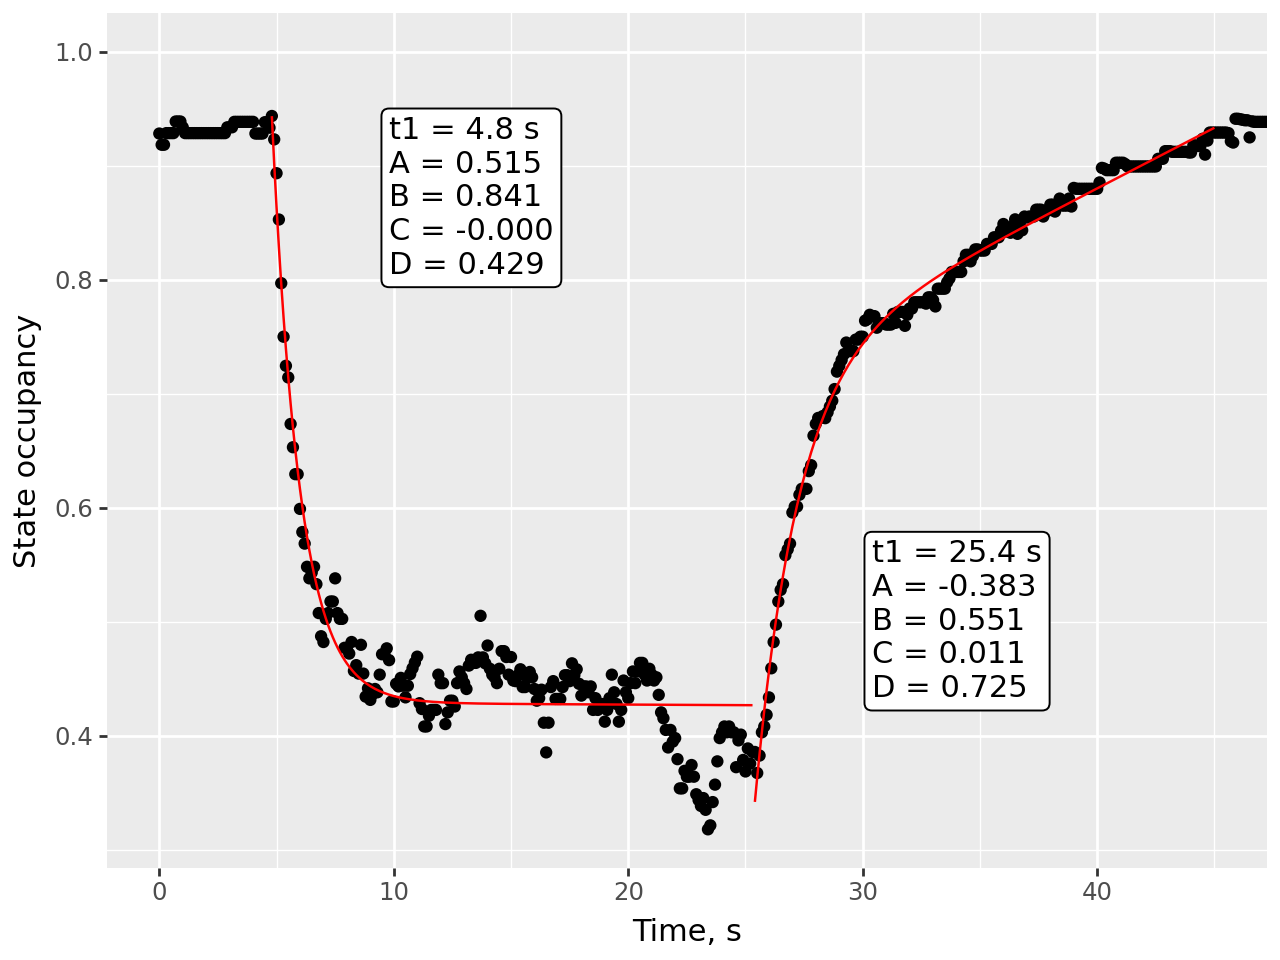

In [208]:
popdata = PopData(ar[np.random.choice(ar.shape[0], 200, replace=True)])
tf = TransitionFitting(popdata, t1=4.8, t2=25.4, t3=45)
tf.ggplot()